Exercise 3
=========

In this exercise you should invetigate model order reduction by a modeal basis.
You should be able to re-use many parts from the previous exercises.

Consider the plate clamped at all edges.

In [50]:
from scipy.io import mmread
from scipy.sparse import csc_matrix
from scipy.sparse.linalg import eigsh
from scipy.sparse.linalg import inv

import numpy as np

import matplotlib as matplot
import matplotlib.pyplot as plt
matplot.rcParams.update({'figure.max_open_warning': 0})

# Uncomment the following line and edit the path to ffmpeg if you want to write the video files!
#plt.rcParams['animation.ffmpeg_path'] ='N:\\Applications\\ffmpeg\\bin\\ffmpeg.exe'

from mpl_toolkits.mplot3d import Axes3D

import sys
# np.set_printoptions(threshold=sys.maxsize)
np.set_printoptions(threshold=20)

from numpy.fft import rfft, rfftfreq

from utility_functions import Newmark

In [51]:
M = csc_matrix(mmread('Ms.mtx')) # mass matrix
K = csc_matrix(mmread('Ks.mtx')) # stiffness matrix
C = csc_matrix(K.shape) # a zeros damping matrix
X = mmread('X.mtx') # coodinate matrix with columns corresponding to x,y,z position of the nodes

N = X.shape[0] # number of nodes

nprec = 6 # precision for finding uniqe values

# get grid vectors (the unique vectors of the x,y,z coodinate-grid)
x = np.unique(np.round(X[:,0],decimals=nprec))
y = np.unique(np.round(X[:,1],decimals=nprec))
z = np.unique(np.round(X[:,2],decimals=nprec))

# grid matrices
Xg = np.reshape(X[:,0],[len(y),len(x),len(z)])
Yg = np.reshape(X[:,1],[len(y),len(x),len(z)])
Zg = np.reshape(X[:,2],[len(y),len(x),len(z)])

tol = 1e-12

# constrain all edges
Nn = np.argwhere(np.abs(X[:,1]-X[:,1].max())<tol).ravel() # Node indices of N-Edge nodes
No = np.argwhere(np.abs(X[:,0]-X[:,0].max())<tol).ravel() # Node indices of O-Edge nodes
Ns = np.argwhere(np.abs(X[:,1]-X[:,1].min())<tol).ravel() # Node indices of S-Edge nodes
Nw = np.argwhere(np.abs(X[:,0]-X[:,0].min())<tol).ravel() # Node indices of W-Edge nodes

Nnosw = np.unique(np.concatenate((Nn,No,Ns,Nw))) #concatenate all and only take unique (remove the double ones)

# indices of x, y, and z DoFs in the global system
# can be used to get DoF-index in global system, e.g. for y of node n by Iy[n]
Ix = np.arange(N)*3 # index of x-dofs
Iy = np.arange(N)*3+1
Iz = np.arange(N)*3+2

# select which indices in the global system must be constrained
If = np.array([Ix[Nnosw],Iy[Nnosw],Iz[Nnosw]]).ravel() # dof indices of fix constraint
Ic = np.array([(i in If) for i in np.arange(3*N)]) # boolean array of constraind dofs

# compute the reduced system
Kc = csc_matrix(K[np.ix_(~Ic,~Ic)])
Mc = csc_matrix(M[np.ix_(~Ic,~Ic)])
Cc = csc_matrix(C[np.ix_(~Ic,~Ic)])

# Constraint Enforcement
You can enforce contraints as in the previous exercises by selecting the appropriate rows from the system matrices, or use the nullsapce of the constraint matrix.

Set up a constraint matrix and use the provided function for computing the nullspace
```python
from utlity_functions import nullspace
```

In [52]:
from utility_functions import nullspace

In [53]:
# B = np.zeros((len(If),3*N)) #Build constraints matrix
# B[np.arange(0,len(If)),np.sort(If)] = 1 #constraint the respective nodes
# Q = nullspace(B) #build the nullspace

In [54]:
# Calc constraint matrixes
# Q = csc_matrix(Q) #or make Q also a sparse and go with that
# K_bar = Q.transpose() @ K @ Q
# M_bar = Q.transpose() @ M @ Q
# C_bar = Q.transpose() @ C @ Q

# Mode Shapes
Compute a set of mode-shapes of the system.

In [131]:
# only compute a subset of modes of the reduced model
k = 10
Wc,Vc = eigsh(Kc,k,Mc,sigma=0,which='LM',maxiter = 1000)

# V = np.zeros([3*N,k])
# V[~Ic,:] = Vc

# M_c = np.zeros([3*N,3*N])
# M_c[~Ic,~Ic] = Mc

In [106]:
# only compute a subset of modes of the reduced model
# k = 10
# W_bar,V_bar = eigsh(K_bar,k,M_bar,sigma=0,which='LM',maxiter = 1000)

## Modal mass participation factor

Compute the modal mass participation factor for all 6  for the first 10 modes of the plate.

First you need to define the ridig body degrees of freedom (3 displacements and 3 rotations) in terms of displacement fields (can be seen as "mode shapes").

In [124]:
W_unconstrained,V_unconstrained = eigsh(K,k,M,sigma=0,which='LM',maxiter = 1000)

In [150]:
def MPF(vi,M,ej) :
    return np.abs((vi @ M @ ej) / (vi @ M @ vi.transpose()))
#     return ((vi @ M @ ej) / (vi @ M @ vi.transpose()))

In [145]:
def plotMPF(ej, title) :
    dependency = np.zeros(k)
    for i,v in enumerate(Vc.T) :
        # dependency[i] = MPF(v, M, ej)
        dependency[i] = MPF(v, Mc, ej[~Ic])
        
    x = range(len(dependency))
    width = 0.75
    plt.bar(x, dependency, width, color="blue")
    plt.ylabel('Measure of coincidance')
    plt.xlabel('Mode index')
    plt.title(title)
    plt.show()

Then compute the 6 modal mass participation factors for each mode.
Which ridid body displacement is most represented in which mode?

In [146]:
# OLD STUFF

# Define rigid body displacements
e_x = np.zeros(3*N)
e_x[Ix] = 1

e_y = np.zeros(3*N)
e_y[Iy] = 1

e_z = np.zeros(3*N)
e_z[Iz] = 1

Center = np.array([0., 0., 0.])
radius = np.zeros(len(X))
for i in range(len(X)) :
    radius[i] = np.linalg.norm(Center - [X[i,:]] )

# Rotation arround the x-axis
e_rx = np.zeros(3*N)
e_rx[Ix] = radius

e_ry = np.zeros(3*N)
e_ry[Iy] = radius

e_rz = np.zeros(3*N)
e_rz[Iz] = radius

# def rotationVector(id_axis) :
#     Center = np.array([0., 0., 0.])
#     rot = np.zeros([beam.nDof,1])

#     radius = np.zeros([len(beam.X),1])
#     for i in range(len(beam.X)) :
#         radius[i,0] = np.linalg.norm(Center - [beam.X[i,:]] )
#     rot[id_axis] = -1*radius
#     return rot

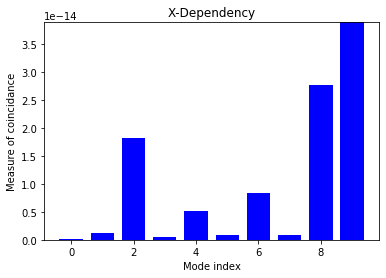

In [151]:
plotMPF(e_x,"X-Dependency")

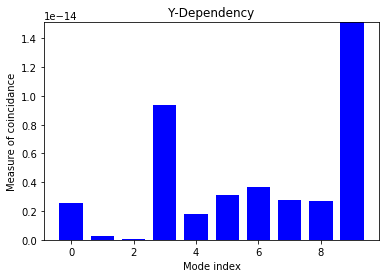

In [152]:
plotMPF(e_y,"Y-Dependency")

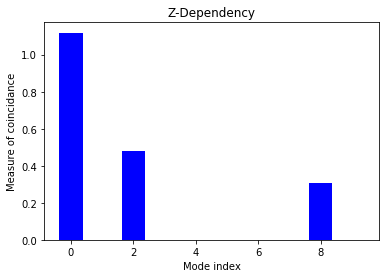

In [153]:
plotMPF(e_z,"Z-Dependency")

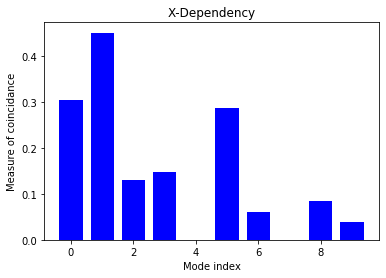

In [79]:
plotMPF(V_unconstrained[:,0],"X-Dependency")

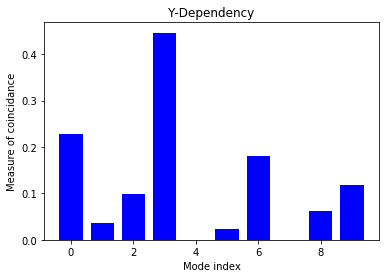

In [80]:
plotMPF(V_unconstrained[:,1],"Y-Dependency")

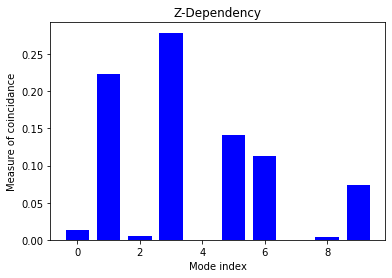

In [81]:
plotMPF(V_unconstrained[:,2],"Z-Dependency")

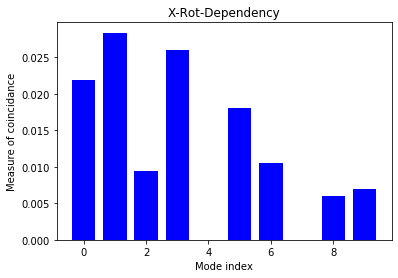

In [82]:
plotMPF(V_unconstrained[:,3],"X-Rot-Dependency")

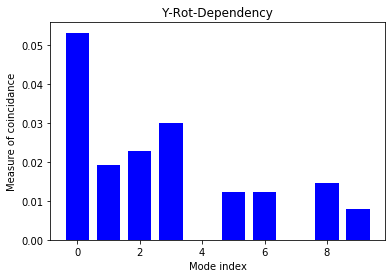

In [83]:
plotMPF(V_unconstrained[:,4],"Y-Rot-Dependency")

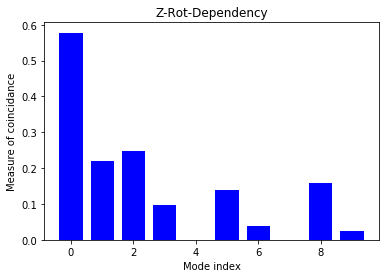

In [84]:
plotMPF(V_unconstrained[:,5],"Z-Rot-Dependency")

# Static Deformation

Check your bondary conditions by computing a static deformation: Assume a pressure acting on the plate (in transverse =z direction) which is linearly increasing from zero at one short edge (e.g. $x=x_{\min}$) to the oppsite edge. 
Assume a maximal pressure of 10kPa.
For the sake of simplicity you can apply the pressure to one "node layer" (in thichness direction).
Force per node can be obtained by multiplying by the "nodal area", i.e. the total area of the plate divided by the number of nodes in the "node layer".

In [ ]:
# Node groups
tol = 1E-12
N_bot = np.argwhere(np.abs(X[:,2]-X[:,2].min())<tol).ravel() # Node indices of bottom nodes 
N_top = np.argwhere(np.abs(X[:,2]-X[:,2].max())<tol).ravel() # Node indices of top nodes 

# Geometry
length_x = np.abs(x.max() - x.min())
length_y = np.abs(y.max() - y.min())
area = length_x * length_y
nodal_area = area / len(N_bot)

# Define loads (constant pressure for verification)
load_constant = np.zeros((3*N,1))
load_linear = np.zeros((3*N,1))
p_max = 10E3 # Max. pressure in Pa
p_mean = p_max / 2
load_constant[Iz[N_bot]] = p_mean * nodal_area 


x_last = 0
for x_current in x: # Iterate over x-coordinates
    step_width = abs(x_current - x_last)
    nodes_current = np.argwhere(np.abs(X[N_bot][:,0] - x_current) < 0.25*step_width).ravel() # Look for according nodes
    pressure = p_max * (x_current - x[0]) / length # Assign linear pressure (Note: zero at X[N_bot,0].min())
    load_linear[Iz[N_bot][nodes_current]] = pressure * nodal_area # Assign load at the current nodes
    x_last = x_current
    print(f"p(x = {x_current:.3f}) = {pressure:.1f}, F = {pressure * nodal_area:.3f} N at nodes = {nodes_current}")
    

# Constrain static system
from utility_functions import nullspace
B = np.zeros((len(If),3*N))
B[np.arange(0,len(If)),np.sort(If)] = 1 #constraint the respective nodes
Q = nullspace(B) #build the nullspace

Q = csc_matrix(Q)
Kc = csc_matrix(Q.T @ K @ Q)
load_constant_constrained = csc_matrix(Q.T @ load_constant)
load_linear_constrained = csc_matrix(Q.T @ load_linear)

In [ ]:
# Check selected nodes
fig,ax = plt.subplots(subplot_kw={'projection':'3d'})

ax.scatter(X[N_bot][:,0],X[N_bot][:,1],X[N_bot][:,2],s=5,label='bot') # undeformed
ax.scatter(X[N_top][:,0],X[N_top][:,1],X[N_top][:,2],s=5,label='top') # undeformed

tol = 1E-12
nodeline = np.argwhere(np.abs(X[N_bot][:,0] - X[N_bot][:,0].min()) < tol).ravel() # Node indices of bottom nodes 


ax.scatter(X[N_bot][nodeline][:,0],X[N_bot][nodeline][:,1],X[N_bot][nodeline][:,2],s=15, c='r', label='first line') # undeformed

print(Iz[N_bot][nodeline])

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.legend()


In [ ]:
from scipy.sparse.linalg import spsolve
uc_constant = spsolve(Kc, load_constant_constrained)
u_constant = Q @ uc_constant
uc_linear = spsolve(Kc, load_linear_constrained)
u_linear = Q @ uc_linear

In [ ]:
# Sanity check for load distribuation
print("LOAD CHARACTERISTIC:")
print(f"Total load: {load_linear.sum() :.1f} N")
print(f"Area: {area :.3f} m^2")
print(f"Calculated mean pressure: {load_linear.sum()/area/1000} kPa")
print(f"Analytic mean pressure: p_max/2 = {p_max/2/1000} kPa")

# Scatter plot
fig,ax = plt.subplots(subplot_kw={'projection':'3d'})

ax.scatter(X[:,0],X[:,1],X[:,2],s=5,label='undeformed') # undeformed

# format U like X
U_constant = np.array([u_constant[Ix],u_constant[Iy],u_constant[Iz]]).T
U_linear = np.array([u_linear[Ix],u_linear[Iy],u_linear[Iz]]).T

# scale factor for plotting
s = max(
    0.5/np.max(np.sqrt(np.sum(U_constant**2,axis=0))),
    0.5/np.max(np.sqrt(np.sum(U_linear**2,axis=0)))
    )

Xu_constant = X + s*U_constant # defomed configuration (displacement scaled by s)
Xu_linear = X + s*U_linear
ax.scatter(Xu_constant[:,0], Xu_constant[:,1], Xu_constant[:,2], s=5, label='const. pressure')
ax.scatter(Xu_linear[:,0], Xu_linear[:,1], Xu_linear[:,2], s=8, label='lin. pressure')
#ax.scatter(Xu_diff[:,0], Xu_diff[:,1], Xu_diff[:,2], s=8, label='difference')

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.legend()


In [ ]:
def plot_3d_deformation(X, u, elev=30.0, azim=60.0):

    # format U like X
    U = np.array([u[Ix],u[Iy],u[Iz]]).T
    s = 0.5/np.max(np.sqrt(np.sum(U**2,axis=0)))
    Xu = X + s*U_linear

    # Set up figure
    fig = plt.figure()
    ax = Axes3D(fig, elev=elev, azim=azim) 
    
    # Plot a basic wireframe.
    index = 1

    x_bot = np.reshape(Xu[N_bot,0],(len(y),len(x)))
    y_bot = np.reshape(Xu[N_bot,1],(len(y),len(x)))
    z_bot = np.reshape(Xu[N_bot,2],(len(y),len(x)))

    x_top = np.reshape(Xu[N_top,0],(len(y),len(x)))
    y_top = np.reshape(Xu[N_top,1],(len(y),len(x)))
    z_top = np.reshape(Xu[N_top,2],(len(y),len(x)))

    x_o = np.reshape(Xu[No,0],(len(y),len(z)))
    y_o = np.reshape(Xu[No,1],(len(y),len(z)))
    z_o = np.reshape(Xu[No,2],(len(y),len(z)))

    x_n = np.reshape(Xu[Nn,0],(len(x),len(z)))
    y_n = np.reshape(Xu[Nn,1],(len(x),len(z)))
    z_n = np.reshape(Xu[Nn,2],(len(x),len(z)))

    x_s = np.reshape(Xu[Ns,0],(len(x),len(z)))
    y_s = np.reshape(Xu[Ns,1],(len(x),len(z)))
    z_s = np.reshape(Xu[Ns,2],(len(x),len(z)))

    x_w = np.reshape(Xu[Nw,0],(len(y),len(z)))
    y_w = np.reshape(Xu[Nw,1],(len(y),len(z)))
    z_w = np.reshape(Xu[Nw,2],(len(y),len(z)))

    sf1 = ax.plot_surface(x_bot, y_bot, z_bot, rstride=index, cstride=index)
    sf2 = ax.plot_surface(x_top, y_top, z_top, rstride=index, cstride=index)
    sf3 = ax.plot_surface(x_o, y_o, z_o, rstride=index, cstride=index)
    sf4 = ax.plot_surface(x_n, y_n, z_n, rstride=index, cstride=index)
    sf5 = ax.plot_surface(x_s, y_s, z_s, rstride=index, cstride=index)
    sf6 = ax.plot_surface(x_w, y_w, z_w, rstride=index, cstride=index)

    ax.set_xlim(-0.3,0.3)
    ax.set_ylim(-0.2,0.2)
    ax.set_zlim(-0.04,0.04)

    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('z')
    pass

plot_3d_deformation(X, u_constant, elev=30, azim=-60)
plot_3d_deformation(X, u_constant, elev=10, azim=0)
plot_3d_deformation(X, u_constant, elev=10, azim=-90)

Approximate the computed static displacement using the first three oscillation modes.
* What are the required modal coordinates?
* Plot the residual, which mode should you include to improve the approximation?

# Transient Solution

We'll investigate the plate in the same configuration as in Exercise 2, but now compute results using reduced order models.

One can use the Newmark time intragration both for the full system and in the modal coodinates.

### Forcing
Use the forcing given in Task 1 of Exercise 2: $f(t) = 1-e^{-(t/0.002)^2}$ in z-direction at $P_1= [0.2,0.12,0.003925]$.

In [ ]:
P1 = [0.2,0.12,0.003925]
N1 = np.argmin(np.sum((X-P1)**2,axis=1))
P2 = [0.0,-0.1,0.003925]
N2 = np.argmin(np.sum((X-P2)**2,axis=1))

Nt = np.argwhere(np.abs(X[:,2]-X[:,2].max())<tol).ravel()

## Functions for TASK 1:

# Define some excitation signals (again for completeness)

def smoothImpulse(t, tau=1, t0=0):
    return np.exp(-(t-t0)/tau)

def smoothStep(t, tau=1, t0=0):
    return 1-smoothImpulse(t, tau, t0)

def gaussianImpulse(t, tau=1, t0=0):
    return np.exp(-((t-t0)/tau)**2)

def gaussianStep(t, tau=1, t0=0): # <-- Thats the one for Task 1 !
    return 1-gaussianImpulse(t, tau, t0)

def unreduce_constrained(uc, Ic):
    """Takes the reduced displacement array uc of shape(m,) and the boolean array Ic of shape(n,) 
    and builds a new unreduced u array of shape(n,)."""
    u = np.zeros((Ic.shape[0], uc.shape[1])) # Initialize unconstrained displacement array
    u[~Ic] = uc
    return u

In [ ]:
def plot_displacements_timedomain(u, time, N1, N2):
    
    # Find node number in the center
    P_center = [0.,0.,0.]
    N_center = np.argmin(np.sum((X-P_center)**2,axis=1))
    
    # Plot
    timePlot, timeAxis = plt.subplots()
    timeAxis.plot(time*1000, u[N1], label = "P1")
    timeAxis.plot(time*1000, u[N2], label = "P2")
    timeAxis.set_xlabel('t [ms]')
    timeAxis.set_ylabel('u(t) [m]')
    timeAxis.legend()

    timePlot_center, timeAxis_center = plt.subplots()
    timeAxis_center.plot(time*1000, u[N_center], label = "P_center")
    timeAxis_center.set_xlabel('t [ms]')
    timeAxis_center.set_ylabel('u(t) [m]')
    timeAxis_center.set_title(f"Displacements - Time Domain")
    timeAxis_center.legend()

def plot_displacements_timedomain_differentmodes(u,u1,u2,u3,u4,time, N1, N2):
    
    # Find node number in the center
    P_center = [0.,0.,0.]
    N_center = np.argmin(np.sum((X-P_center)**2,axis=1))
    
    # Plot
    timePlot, timeAxis = plt.subplots()
    timeAxis.plot(time*1000, u[N1], label = "P1")
    timeAxis.plot(time*1000, u1[N1], label = "P1_modes2")
    timeAxis.plot(time*1000, u2[N1], label = "P1_modes15")
    timeAxis.plot(time*1000, u3[N1], label = "P1_modes30")
    timeAxis.plot(time*1000, u4[N1], label = "P1_modes100")
    timeAxis.plot(time*1000, u[N2], label = "P2")
    timeAxis.plot(time*1000, u1[N2], label = "P2_modes2")
    timeAxis.plot(time*1000, u2[N2], label = "P2_modes15")
    timeAxis.plot(time*1000, u3[N2], label = "P2_modes30")
    timeAxis.plot(time*1000, u4[N2], label = "P2_modes100")
    timeAxis.plot(time*1000,u[N_center], label ="P_center")
    timeAxis.plot(time*1000, u1[N_center], label = "P_center_modes2")
    timeAxis.plot(time*1000, u2[N_center], label = "P_center_modes15")
    timeAxis.plot(time*1000, u3[N_center], label = "P_center_modes30")
    timeAxis.plot(time*1000, u4[N_center], label = "P_center_modes100")
    timeAxis.set_xlabel('t [ms]')
    timeAxis.set_ylabel('u(t) [m]')
    timeAxis.legend()
    
def plot_P1_timedomain(u, time, N1):
    
    # Plot
    timePlot, timeAxis = plt.subplots()
    timeAxis.plot(time*1000, u[N1], label = "P1")
    timeAxis.set_xlabel('t [ms]')
    timeAxis.set_ylabel('u(t) [m]')
    timeAxis.set_title(f"Displacement - Time Domain")
    timeAxis.legend()
    
def plot_P2_timedomain(u, time, N2):
    
    # Plot
    timePlot, timeAxis = plt.subplots()
    timeAxis.plot(time*1000, u[N2], label = "P2")
    timeAxis.set_xlabel('t [ms]')
    timeAxis.set_ylabel('u(t) [m]')
    timeAxis.set_title(f"Displacement - Time Domain")
    timeAxis.legend()
    
def plot_different_P1_timedomain(u,u1,u2,u3,time,N1):
    # Plot
    timePlot, timeAxis = plt.subplots()
    timeAxis.plot(time*1000, u[N1], label = "P1_mode2")
    timeAxis.plot(time*1000, u1[N1], label = "P1_mode3")
    timeAxis.plot(time*1000, u2[N1], label = "P1_mode5")
    timeAxis.plot(time*1000, u3[N1], label = "P1_full")
    timeAxis.set_xlabel('t [ms]')
    timeAxis.set_ylabel('u(t) [m]')
    timeAxis.set_title(f"Displacement - Time Domain")
    timeAxis.legend()
    
def plot_different_P2_timedomain(u,u1,u2,u3,time,N2):
    # Plot
    timePlot, timeAxis = plt.subplots()
    timeAxis.plot(time*1000, u[N2], label = "P2_mode2")
    timeAxis.plot(time*1000, u1[N2], label = "P2_mode3")
    timeAxis.plot(time*1000, u2[N2], label = "P2_mode5")
    timeAxis.plot(time*1000, u3[N2], label = "P2_full")
    timeAxis.set_xlabel('t [ms]')
    timeAxis.set_ylabel('u(t) [m]')
    timeAxis.set_title(f"Displacement - Time Domain")
    timeAxis.legend()

def plot_different_PCenter_timedomain(u,u1,u2,u3,time,X):
    
    #Find node number in the center
    P_center = [0.,0.,0.]
    N_center = np.argmin(np.sum((X-P_center)**2,axis=1))
    
    # Plot
    timePlot, timeAxis = plt.subplots()
    timeAxis.plot(time*1000, u[N_center], label = "PCenter_mode2")
    timeAxis.plot(time*1000, u1[N_center], label = "PCenter_mode3")
    timeAxis.plot(time*1000, u2[N_center], label = "PCenter_mode5")
    timeAxis.plot(time*1000, u3[N_center], label = "PCenter_full")
    timeAxis.set_xlabel('t [ms]')
    timeAxis.set_ylabel('u(t) [m]')
    timeAxis.set_title(f"Displacement - Time Domain")
    timeAxis.legend()
    
def compare_modalmodes(u_modal,u_full,time, N1, N2):
    
    # Plot
    timePlot, timeAxis = plt.subplots()
    timeAxis.plot(time*1000, u_modal[N1], label = "P1_modal")
    timeAxis.plot(time*1000, u_full[N1], label = "P1_full")

    timeAxis.plot(time*1000, u_modal[N2], label = "P2_modal")
    timeAxis.plot(time*1000, u_full[N2], label = "P2_full")

    timeAxis.set_xlabel('t [ms]')
    timeAxis.set_ylabel('u(t) [m]')
    timeAxis.legend()
    
def plot_modalcoordinates(uc,time):
    #plot
    timePlot, timeAxis = plt.subplots()
    for i in range(0,len(uc),1):
        timeAxis.plot(time*1000, uc[i], label = "Modal%s" %i)
    timeAxis.set_xlabel('t [ms]')
    timeAxis.set_ylabel('Madalcoordinates(t) [m]')
    timeAxis.legend()

### Damping
For the sake of simplicity assume Rayleigh damping with $\alpha=2.15$ and $\beta=3e-5$.

In [ ]:
#Define alpha & beta
alpha = 2.15
beta = 3e-5

def full_excitation_analysis(tau=0.002, T=0.2, 
                             excitation_type='step', 
                             display_animation=False, k = None):
       
    # Assign load
    if excitation_type == 'step':
        
        # integration time
        f_max = 1/tau # Very crude estimation of max frequency.
        dt = 1/(20*f_max) # Timestep 
        time = np.arange(0, T, dt) # Create time array for integration
        
        load = gaussianStep(time, tau)
        
    elif excitation_type == 'impulse':
        
        # integration time
        f_max = 5/tau # Very crude estimation of max frequency.
        dt = 1/(20*f_max) # Timestep 
        time = np.arange(0, T, dt) # Create time array for integration
        
        load = gaussianImpulse(time, tau)
        
    # Checkout load function
    #plot_load_analysis(load, time) # Plot that thing.

    # Construct Constrained System
    N = K.shape[0]//3 # Get number of nodes! Note: 3*N = DoF.

    Cc = alpha*Mc + beta*Kc # Construct the proportional damping matrix with pre-determined alpha and beta values.

    f = np.array(np.zeros((3*N, time.shape[0]))) # Initialize load vector array; Note that the columns contain the force values from 0 to T!
    f[Iz[N1]] = load # Assign load function at point N1 in z-direction.
    fc = f[~Ic] # Reduce load array.
        
    #Cheking if full system is used or modal system
    if k == None:
    
        u0 = np.zeros(3*N) # Initial displacement set to 0.
        u0c = u0[~Ic] # Reduce displacement vector.

        # Time Integration
        uc, vc, ac = Newmark(Mc, Cc ,Kc , fc, time, u0c)
        u = unreduce_constrained(uc, Ic) # Collect the displacement constraints in the unreduced displacement array.
        

        # Plot P1
        #plot_P1_timedomain(u, time, N1)
        
        #Plot P2
        #plot_P2_timedomain(u, time, N2)
        
        return u, uc
    else:
        # only compute a subset of modes of the reduced model
        W,V = eigsh(Kc,k,Mc,sigma=0,which='LM',maxiter = 1000)
        
        #Compute modal system matrices
        Km = V.T @ Kc @ V
        Mm = V.T @ Mc @ V
        Cm = V.T @ Cc @ V
        fm = V.T @ fc
        
        #define displacement vector
        u0c = np.array(np.zeros(len(fm),))
        
        # Time Integration
        uc, vc, ac = Newmark(Mm, Cm ,Km , fm, time, u0c)
        
        full_solution = V @ uc
        
        u = unreduce_constrained(full_solution, Ic) # Collect the displacement constraints in the unreduced displacement array.
        
        
        # Plot P1
        #plot_P1_timedomain(u, time, N1)
        
        #Plot P2
        #plot_P2_timedomain(u, time, N2) 
        return u, uc

In [ ]:
u, uc = full_excitation_analysis(tau=0.002, T=0.2, excitation_type='step',k=2)

## Task 1: Transient Response using Reduced Model

Use a modal basis of the first two modes and compute the transient response of the system (under the same loading as in Task 1 of Exercise 2). Plot the response at points P1 and P2, and compare with the full system.
What is the error with respect to the full system?

In [ ]:
u_modal, uc_modal = full_excitation_analysis(tau=0.002, T=0.2, excitation_type='step',k=2)

f_max = 1/0.002 # Very crude estimation of max frequency.
dt = 1/(20*f_max) # Timestep 
time = np.arange(0, 0.2, dt)

#plot P1 & P2 for 2 modes
plot_P1_timedomain(u_modal, time, N1)
plot_P2_timedomain(u_modal, time, N2)

In [ ]:
u_full, uc_full = full_excitation_analysis(tau=0.002, T=0.2, excitation_type='step')

#plot P1 & P2 for full system
plot_P1_timedomain(u_full, time, N1)
plot_P2_timedomain(u_full, time, N2)

In [ ]:
u_error_modal = u_full - u_modal

#Compare modalmodes with full system
compare_modalmodes(u_modal,u_full,time, N1, N2)

### Choice of Modes
* How does the error improve when you take more modes?
* Plot the response at selected nodes, e.g. N1, N2, center, for different models in the same graph.

In [ ]:
u_mode3, uc_mode3 = full_excitation_analysis(tau=0.002, T=0.2, excitation_type='step', k=3)
u_mode5, uc_mode5 = full_excitation_analysis(tau=0.002, T=0.2, excitation_type='step', k=5)
u_mode10, uc_mode10 = full_excitation_analysis(tau=0.002, T=0.2, excitation_type='step', k=10)

In [ ]:
#plot P1 for different modes
plot_different_P1_timedomain(u_modal,u_mode3,u_mode5,u_full,time,N1)

#plot P2 for different modes
plot_different_P2_timedomain(u_modal,u_mode3,u_mode5,u_full,time,N2)

#plot P_Center for different modes
plot_different_PCenter_timedomain(u_modal,u_mode3,u_mode5,u_full,time,X)

#one can see that the error decreases significantly with more modes. in this case modal modes more than 6 is good

In [ ]:
#Comparing error
u_error_mode3 = u_full - u_mode3
u_error_mode5 = u_full - u_mode5
u_error_mode10 = u_full - u_mode10

plot_different_P1_timedomain(u_error_modal,u_error_mode3,u_error_mode5,u_error_mode10,time,N1)

#plot P2 for different modes
plot_different_P2_timedomain(u_error_modal,u_error_mode3,u_error_mode5,u_error_mode10,time,N2)

### Time Evolution of Modal Corrdinates
* Visualize the time evolution of the used modal coordinates
* Do this for the results obtained with differnt modal bases
* Compute the modal contributions in the same way. Which modes contribute most for which model?

In [ ]:
#Visualizing time evoultion of the modal cooridnates for different modal bsases
plot_modalcoordinates(uc_modal,time)
plot_modalcoordinates(uc_mode3,time)
plot_modalcoordinates(uc_mode5,time)
plot_modalcoordinates(uc_mode10,time)

In [ ]:
#Define a function that computes rho for diffferent modal cooridnates
def plot_rho(uc): 
    rho = uc/np.linalg.norm(uc)
    Plot, Axis = plt.subplots()
    for i in range(0,len(uc),1):
        Axis.plot(uc[i], rho[i] , label = "Rho%s" %i)
    Axis.set_xlabel('Modes')
    Axis.set_ylabel('Rho')
    Axis.legend()

In [ ]:
#Visualizing time evoultion of the modal cooridnates for different modal bsases
plot_rho(uc_modal)
plot_rho(uc_mode3)
plot_rho(uc_mode5)
plot_rho(uc_mode10)

# Steady State Oscillation | Frequency Domain

Now switch to frequency domain and compute the steady state response of the system.
For the sake of simplicity use a unit excitation at $P_1$.

In [ ]:
from numpy.linalg import solve
import time

In [ ]:
def FrequencyDomain(omega, direc = Iz, node = N1, K = Kc, C = Cc, M = Mc):
    #1. Compute the dynamic stiffness matrix Z for one omega
    Z = K + complex(0,1) * omega * C - omega**2 * M     
    
    #2. Assemble one (or several) forcing vectors
    f_hat = np.zeros(3*N)
    f_hat[direc[node]] = 1.0    #for sys without constrains and force acting on N1 which is the closest node to P1
    fc_hat = f_hat[~Ic]    #for reduced sys, because of constrains
    
    fc_hat_red = V.transpose() @ fc_hat #reduced forcing vector
    
    #3. solve for the displacements
    xc_hat_red = solve(Z,fc_hat_red)       #for np.array matrices
    
    return(xc_hat_red) #complex, so ampl and phase is in there; for all DoF which are not constrained

## Task 2: Compute Harmonic Response using a Reduced Model

Use the first 10 modes to compute the steady state response for a unit forcing in z-direction at $P_1$.
Do the computation for Rayleigh damping and for Modal damping with a damping ratio of 0.01 for each mode.
Compare the results by plotting the transfer functions up to 300Hz.

In [ ]:
## only compute a subset of modes of the reduced model
k = 10
W,V = eigsh(Kc,k,Mc,sigma=0,which='LM',maxiter = 1000)

In [ ]:
def ResponseOverReducedSystem(max_freq = 300, min_freq = 2, Nr_steps = 150):
    
    ## Compute the reduced system matrices and forcing vector
    M_red = V.transpose() @ Mc @ V
    C_red = V.transpose() @ Cc @ V
    K_red = V.transpose() @ Kc @ V

    ## Solve the reduced system for the modal coordinates eta and transforamtion to obtain the full solution
    eta_hat_store = []
    
    freq = np.linspace(min_freq, max_freq, Nr_steps)
    P1_resp_z = np.zeros([len(freq), 2])

    for i,f in enumerate(freq):
        # response of the reduced system M_red K_red C_red
        eta_hat = FrequencyDomain(omega = 2*np.pi*f, K = K_red, C = C_red, M = M_red)
        eta_hat_store.append(eta_hat)

        # coordinate transformation to obtain the full solution
        resp = V @ eta_hat

        # insert missing nodes with zero, because of the constrains
        resp_all = np.zeros(N*3) + complex(0,0)
        resp_all[~Ic] = resp

        #Amplitude displacement
        #P1_resp_z[counter,0] = 20*np.log10(np.abs(resp_all[Iz[N1]]))
        P1_resp_z[i,0] = np.abs(resp_all[Iz[N1]])

        #Phase in degree
        P1_resp_z[i,1] = np.angle(resp_all[Iz[N1]])*180/np.pi

    eta_hat_store = np.asarray(eta_hat_store)
    
    return(P1_resp_z, eta_hat_store, freq)

In [ ]:
dampingRatio = 0.01 # Damping ratio choosen

In [ ]:
### Rayleigh damping like ex.2
## getting alpha and beta
omegas = np.sqrt(abs(W)) # Collect angular eigenfrq.
omegaCoeffs = np.vstack((0.5/omegas, omegas*0.5)).T # Build coefficent matrix  

b = dampingRatio*np.ones(np.shape(omegaCoeffs)[0]) # Right-hand side of omegaCoeffs*alphaBeta = b

alphaBeta = np.linalg.solve(omegaCoeffs[(0,4),:], b.take([0,4])) # Solve for alphaBeta at 1. and 5. natural frequency

dampingRatios = omegaCoeffs @ alphaBeta 

start_time = time.time()

## assemble Damping-Matrix for the reduced sys and given aplha and beta for Rayleigh damping
alpha = alphaBeta[0]
beta = alphaBeta[1]
Cc = alpha * Mc + beta * Kc

response_ModalCoordinates_frequency = ResponseOverReducedSystem()
P1_resp_z_ray = response_ModalCoordinates_frequency[0]
eta_hat_ray = response_ModalCoordinates_frequency[1]
frequency_ray = response_ModalCoordinates_frequency[2]

print("--- %s seconds ---" % (time.time() - start_time))

In [ ]:
### Modal damping
start_time = time.time()

##  assemble Cc-Matrix
container = np.array(2*np.sqrt(W)*dampingRatio)
diagMiddle = np.diag(container)
Cc = V @ diagMiddle @ V.transpose()

response_ModalCoordinates_frequency = ResponseOverReducedSystem()
P1_resp_z_mod = response_ModalCoordinates_frequency[0]
eta_hat_mod = response_ModalCoordinates_frequency[1]
frequency_mod = response_ModalCoordinates_frequency[2]

print("--- %s seconds ---" % (time.time() - start_time))

In [ ]:
### Plot of transfer functions up to 300Hz (Bode-Diag.)

#plot response in z for P1 with Rayleigh damping
plt.plot(frequency_ray, P1_resp_z_ray[:,0])
plt.title('resp. P1, z-disp., Rayleigh damping')
plt.ylabel('Amplitude')
plt.xlabel('Frequency (1/s)')
# plt.xscale('log')
# plt.xlim(1, 1000)
plt.grid(True)
plt.show()

plt.plot(frequency_ray, P1_resp_z_ray[:,1])
plt.ylabel('Phase (deg)')
plt.xlabel('Frequency (1/s)')
# plt.xscale('log')
# plt.xlim(1, 1000)
plt.grid(True)
plt.show()

#plot response in z for P1 with Modal damping
plt.plot(frequency_mod, P1_resp_z_mod[:,0])
plt.title('resp. P1, z-disp., Modal damping')
plt.ylabel('Amplitude')
plt.xlabel('Frequency (1/s)')
# plt.xscale('log')
# plt.xlim(1, 1000)
plt.grid(True)
plt.show()

plt.plot(frequency_mod, P1_resp_z_mod[:,1])
plt.ylabel('Phase (deg)')
plt.xlabel('Frequency (1/s)')
#plt.xscale('log')
#plt.xlim(1, 1000)
plt.grid(True)
plt.show()

### Compare damping models
* what is the difference between modal and Rayleigh damping?
* what happens if you only damp certain modes with modal damping?

In [ ]:
#plot response in z for P1 with Rayleigh damping and Modal damping
plt.plot(frequency_ray, P1_resp_z_ray[:,0], label = 'Rayleigh')
plt.plot(frequency_mod, P1_resp_z_mod[:,0], label = 'Modal')
plt.title('resp. P1, z-disp.')
plt.ylabel('Amplitude')
plt.xlabel('Frequency (1/s)')
# plt.xscale('log')
# plt.xlim(1, 1000)
plt.grid(True)
plt.legend()
plt.show()

In [ ]:
## only damp certain modes with modal damping

### assemble Cc-Matrix; only damp first mode with modal damping
container = np.zeros(len(W))
which_mode = 0
container[which_mode] = 2*np.sqrt(W[which_mode])*dampingRatio
diagMiddle = np.diag(container)
Cc = V @ diagMiddle @ V.transpose()

response_ModalCoordinates_frequency = ResponseOverReducedSystem()
P1_resp_z_mod_first = response_ModalCoordinates_frequency[0]
eta_hat_mod_first = response_ModalCoordinates_frequency[1]
frequency_first = response_ModalCoordinates_frequency[2]

### assemble Cc-Matrix; only damp second mode with modal damping
container = np.zeros(len(W))
which_mode = 1
container[which_mode] = 2*np.sqrt(W[which_mode])*dampingRatio
diagMiddle = np.diag(container)
Cc = V @ diagMiddle @ V.transpose()

response_ModalCoordinates_frequency = ResponseOverReducedSystem()
P1_resp_z_mod_second = response_ModalCoordinates_frequency[0]
eta_hat_mod_second = response_ModalCoordinates_frequency[1]
frequency_second = response_ModalCoordinates_frequency[2]

### assemble Cc-Matrix; only damp the seventh mode with modal damping
container = np.zeros(len(W))
which_mode = 6
container[which_mode] = 2*np.sqrt(W[which_mode])*dampingRatio
diagMiddle = np.diag(container)
Cc = V @ diagMiddle @ V.transpose()

response_ModalCoordinates_frequency = ResponseOverReducedSystem()
P1_resp_z_mod_seventh = response_ModalCoordinates_frequency[0]
eta_hat_mod_seventh = response_ModalCoordinates_frequency[1]
frequency_seventh = response_ModalCoordinates_frequency[2]

In [ ]:
#plot response in z for P1 with Modal damping on certain modes
plt.plot(frequency_ray, P1_resp_z_mod_first[:,0], label = 'first mode')
plt.plot(frequency_mod, P1_resp_z_mod_second[:,0], label = 'second mode')
# plt.plot(frequency_mod, P1_resp_z_mod_seventh[:,0], label = 'seventh mode')
plt.title('resp. P1, z-disp.')
plt.ylabel('Amplitude')
plt.xlabel('Frequency (1/s)')
# plt.xscale('log')
# plt.xlim(1, 1000)
plt.grid(True)
plt.legend()
plt.show()

#plot response in z for P1 with Modal damping on seventh mode (last under 300Hz)
plt.plot(frequency_mod, P1_resp_z_mod_seventh[:,0], label = 'seventh mode')
plt.title('resp. P1, z-disp.')
plt.ylabel('Amplitude')
plt.xlabel('Frequency (1/s)')
# plt.xscale('log')
plt.ylim(-0.00005, 0.0007)
plt.grid(True)
plt.legend()
plt.show()

In [ ]:
# Output of the natural frequencies for illustration
print(np.sqrt(W)/2/np.pi)

### Modal contribution
* compute the modal contribution factors for each mode and plot them over the frequency
* When is which mode important?

In [ ]:
### Modal Contribution factor for each mode
frequency = frequency_ray
eta = eta_hat_ray

rho = np.zeros([k, len(frequency)],dtype=float)

for i,f in enumerate(frequency):
    data = eta[i,:]
    
    rho[:,i] = np.abs(data)/np.linalg.norm(data)
    rho[:,i] = rho[:,i]/np.sum(rho[:,i])

In [ ]:
#plot modal Contribution Factor over the frequency 1.Mode

for i,values in enumerate(rho) :   
    plt.plot(frequency, rho[i,:])
    plt.title('Modal Contribution Factor over Frequency ' + str(i+1) + '.Mode')
    plt.ylabel('rho')
    plt.xlabel('Frequency (1/s)')
    plt.grid(True)
    plt.show()

In [ ]:
# ## pLot modal contribution of the modes

# for i,values in enumerate(rho) :   
#     fig, ax = plt.subplots(figsize=(20,8))
#     ax.plot(rho[:,i])
#     ax.set_xlabel('modes')
#     ax.set_ylabel('modal contribution')
#     plt.title('modal contribution of the' + str(i+1) + '.Mode')
#     plt.grid(True)
# #     plt.legend()
#     plt.show()